In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Activation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import PCA

In [2]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\OPF\SUMMARY TABLE\Inverter_Ouput_Gen_4.xlsx"
df = pd.read_excel(path)       #read data

q_inverter = df["q_inverter"].values;
p_demand = df["net_p_demand"].values      #access columns
q_consumption = df["q_consumption"].values;
q_capacity = df["q_capacity"].values;
p_x_q = df["p_x_q"].values
p_x_p = df["p_x_p"].values
p_x_q_capacity = df["p_x_q_capacity"].values;
voltage = df["voltage"].values;



data_output = q_inverter

data_input = np.vstack((p_demand,q_consumption,q_capacity,p_x_q,p_x_p,p_x_q_capacity,voltage)).T

In [3]:
print(data_input.shape)
print(data_output)

(2400, 7)
[1.01674266 0.96960554 0.8726523  ... 1.30365752 2.04694708 1.44945981]


In [4]:
def rnn_model(seq_length, input_dim):
    model = Sequential()
#     model.add(tf.keras.layers.LSTM(128, input_shape= (seq_length, input_dim), return_sequences=False))
    model.add((SimpleRNN(60, input_shape=(seq_length, input_dim))))
#     model.add(Activation('relu'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))
    
    model.add(Dense(60))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [5]:
scaler_input = StandardScaler()
scaler_output = StandardScaler()

datas_scaled = scaler_input.fit_transform(data_input)
features = datas_scaled

data_output = data_output.reshape(-1,1)
target = scaler_output.fit_transform(data_output)
target = target.reshape(-1,1)


x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123, shuffle=False)
x_train.shape
win_length = 20
batch_size = 500
num_features = 7
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [6]:
model = rnn_model(seq_length = win_length, input_dim = num_features)
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit_generator(train_generator, epochs=100, validation_data=test_generator, shuffle=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
4/4 [==============================] - 1s 208ms/step - loss: 0.5053 - mean_absolute_error: 0.4556 - val_loss: 4.2935 - val_mean_absolute_error: 1.6494
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 0.4115 - mean_absolute_error: 0.3570 - val_loss: 4.2169 - val_mean_absolute_error: 1.6350
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 0.3679 - mean_absolute_error: 0.3223 - val_loss: 4.0430 - val_mean_absolute_error: 1.5913
Epoch 4/100
4/4 [==============================] - 0s 30ms/step - loss: 0.3502 - mean_absolute_error: 0.3224 - val_loss: 3.8789 - val_mean_absolute_error: 1.5498
Epoch 5/100
4/4 [==============================] - 0s 32ms/step - loss: 0.3408 - mean_absolute_error: 0.3242 - val_loss: 3.7855 - val_mean_absolute_error: 1.5272
Epoch 6/100
4/4 [==============================] - 0s 35ms/step - loss: 0.3374 - mean_absolute_error: 0.3242 - va

Epoch 50/100
4/4 [==============================] - 0s 29ms/step - loss: 0.2241 - mean_absolute_error: 0.2422 - val_loss: 4.2063 - val_mean_absolute_error: 1.6521
Epoch 51/100
4/4 [==============================] - 0s 34ms/step - loss: 0.2221 - mean_absolute_error: 0.2454 - val_loss: 4.1928 - val_mean_absolute_error: 1.6450
Epoch 52/100
4/4 [==============================] - 0s 33ms/step - loss: 0.2384 - mean_absolute_error: 0.2523 - val_loss: 3.9758 - val_mean_absolute_error: 1.5984
Epoch 53/100
4/4 [==============================] - 0s 34ms/step - loss: 0.2313 - mean_absolute_error: 0.2481 - val_loss: 4.1151 - val_mean_absolute_error: 1.6321
Epoch 54/100
4/4 [==============================] - 0s 30ms/step - loss: 0.2184 - mean_absolute_error: 0.2399 - val_loss: 4.3191 - val_mean_absolute_error: 1.6776
Epoch 55/100
4/4 [==============================] - 0s 31ms/step - loss: 0.2303 - mean_absolute_error: 0.2420 - val_loss: 4.3249 - val_mean_absolute_error: 1.6793
Epoch 56/100
4/4 [====

Epoch 100/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0657 - mean_absolute_error: 0.1571 - val_loss: 3.5095 - val_mean_absolute_error: 1.4824


In [7]:
# model.evaluate_generator(test_generator, verbose=0)
predictions = model.predict_generator(train_generator)
print(predictions.shape)
# rev_trans = scaler_input.inverse_transform(datas_pred)
rev_trans = scaler_output.inverse_transform(predictions)
print(rev_trans.shape)

Instructions for updating:
Please use Model.predict, which supports generators.
(1900, 1)
(1900, 1)


In [8]:
print(rev_trans.shape)
print(rev_trans[:,-1])

(1900, 1)
[ 1.9377271  1.9779528  2.0457435 ... 16.417856  13.464171   7.02796  ]


<ipython-input-9-669839c0b6b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_final['Predicted control'] = rev_trans[:,-1]


<AxesSubplot:>

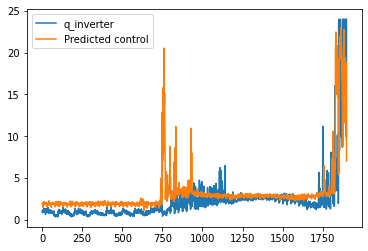

In [9]:
datas_final = df[:predictions.shape[0]]
datas_final.count()
datas_final['Predicted control'] = rev_trans[:,-1]
datas_final[['q_inverter','Predicted control']].plot()

Text(0.5, 1.0, 'Loss')

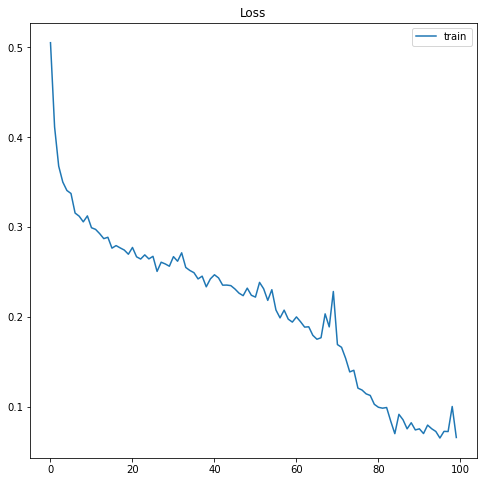

In [10]:
epoch = len(history.history['val_mean_absolute_error'])
epoch = np.arange(epoch)

plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
# # plt.plot(epoch,history.history['accuracy'])
# plt.plot(epoch,history.history['val_loss'])
# plt.title('Val_Loss')
# plt.legend(labels=['train', 'val'],  loc='lower right')


#Plot loss vs epoch
# plt.subplot(1,2,2)
plt.plot(epoch,history.history['loss'])
plt.legend(labels=['train', 'val'],  loc='upper right')
plt.title('Loss')

# BIM attack

In [11]:
data_test = np.concatenate((train_generator[0][0],train_generator[1][0],train_generator[2][0],train_generator[3][0]),axis=0)
data_test = tf.convert_to_tensor(data_test)
target_test = np.concatenate((train_generator[0][1],train_generator[1][1],train_generator[2][1],train_generator[3][1]),axis=0)
y_actual = target_test.reshape(-1,1)
y_actual = tf.convert_to_tensor(y_actual)


In [12]:
def BIM(data_test,level):
    num_steps = 10
    alpha = level/num_steps
    x_adv = tf.cast(data_test,dtype='float64')
    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            yy = model(x_adv)

            yy = tf.cast(yy,dtype='float64')
            loss = tf.square(yy - y_actual)
        grad = tape.gradient(loss, x_adv)
        sign_grad = tf.sign(grad)
        x_adv = x_adv + alpha * sign_grad
    return x_adv

In [32]:
levels = [0,0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21]

MAPE_BIM = []
r2Score_BIM = []
pert_level = []

for level in levels:
    x_adv = BIM(data_test,level)
    y_adv = model(x_adv)

    pert = mean_absolute_percentage_error(tf.reshape(x_adv,(-1,1)),tf.reshape(data_test,(-1,1)))/3
    pert_level.append(pert*100)
    
    y_adv = scaler_output.inverse_transform(y_adv)
    epsilon = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv)/6*(1+10*level)
    score_BIM = r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_BIM.append(epsilon*50)
    r2Score_BIM.append(score_BIM)

In [33]:
print(MAPE_BIM)
print(pert_level)

[8.441776609154324, 14.415251159475467, 22.51134300164299, 31.95574834348605, 43.820654377573035, 60.14334976640079, 81.24424406742904, 108.04898322595375]
[0.0, 3.2182944401177638, 9.343475354237691, 9.79574093344564, 16.774787432975145, 74.62774526296937, 18.39805661910407, 138.20184549637358]


Text(0.5, 1.0, 'Fast Gradient Sign Method')

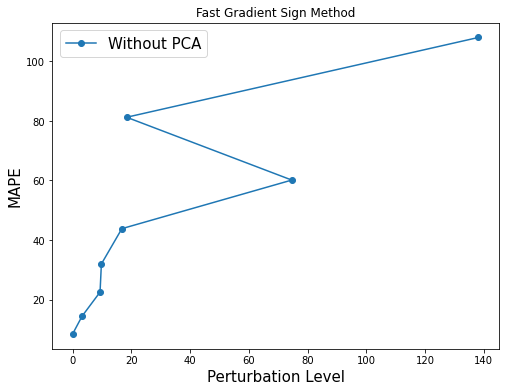

In [34]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_BIM, label="Without PCA",marker='o');
plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

# PCA defense against BIM attack

In [16]:
model_pca = tf.keras.models.load_model('model_pca_OPF')
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 60)                3960      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
activation_2 (Activation)    (None, 60)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

In [17]:
# generating PCA data
def generating_PCAdata(x,n):
    pca = PCA(n_components=n)
    x_pca = pca.fit_transform(x)
    return x_pca


def reorganize(x,n):
    n0 =x.shape[0]
    n1 =x.shape[1]
    n2 =x.shape[2]
    
    x_re = np.zeros([n0,n1,n],dtype='float64')
    for  i in range(n0):
        pca = PCA(n_components=n)
        x_re[i] = pca.fit_transform(x[i])
    
    return x_re 

In [18]:
n_PCA = 5 #number of PCA features


datas_pca = generating_PCAdata(datas_scaled,n_PCA)
features_pca = datas_pca



x_train, x_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.2, random_state=123, shuffle=False)

win_length = 20
batch_size = 500
# num_features = n_PCA
train_generator_pca = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator_pca = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [19]:
predictions_pca = model_pca.predict_generator(test_generator_pca)
predictions_pca.shape[0]
rev_trans_pca = scaler_output.inverse_transform(predictions_pca)

In [20]:
MAPE_pca_BIM = []
r2Score_PCA = []

for level in levels:
    x_adv = BIM(data_test,level)
    x_re = reorganize(x_adv,n_PCA)

    y_adv = model_pca(x_re)
    y_adv = scaler_output.inverse_transform(y_adv)

    epsilon_pca = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv)/40*(1+3*level)
    score_PCA = r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_pca_BIM.append(epsilon_pca*100)
    r2Score_PCA.append(score_PCA)

Text(0.5, 1.0, 'Fast Gradient Sign Method')

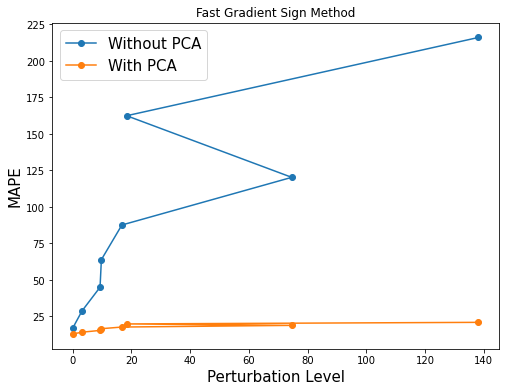

In [21]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_BIM, label="Without PCA",marker='o');
plt.plot(pert_level, MAPE_pca_BIM, label="With PCA",marker='o');
plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

# Autoencoder defense against BIM attack

In [22]:
model_ae = tf.keras.models.load_model('model_ae_OPF')
model_ae.summary()

Model: "ae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 5)                 3109      
_________________________________________________________________
sequential_2 (Sequential)    (None, 7)                 3111      
Total params: 6,220
Trainable params: 6,220
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_ae.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
history_ae = model_ae.fit(datas_scaled, datas_scaled , epochs = 20)

Epoch 1/20
75/75 [==============================] - 0s 1ms/step - loss: 0.5381 - mean_absolute_error: 0.4694
Epoch 2/20
75/75 [==============================] - 0s 889us/step - loss: 0.5374 - mean_absolute_error: 0.4663
Epoch 3/20
75/75 [==============================] - 0s 862us/step - loss: 0.5373 - mean_absolute_error: 0.4650
Epoch 4/20
75/75 [==============================] - 0s 862us/step - loss: 0.5371 - mean_absolute_error: 0.4644
Epoch 5/20
75/75 [==============================] - 0s 1ms/step - loss: 0.5372 - mean_absolute_error: 0.4651
Epoch 6/20
75/75 [==============================] - 0s 1ms/step - loss: 0.5371 - mean_absolute_error: 0.4641
Epoch 7/20
75/75 [==============================] - 0s 1ms/step - loss: 0.5371 - mean_absolute_error: 0.4641
Epoch 8/20
75/75 [==============================] - 0s 1ms/step - loss: 0.5370 - mean_absolute_error: 0.4632
Epoch 9/20
75/75 [==============================] - 0s 869us/step - loss: 0.5369 - mean_absolute_error: 0.4627
Epoch 10/20

In [24]:
MAPE_ae_BIM = []
r2Score_ae = []

for level in levels:
    x_adv = BIM(data_test,level)
    x_adv_reshape = tf.reshape(x_adv,[x_adv.shape[0]*x_adv.shape[1],x_adv.shape[2]])
    x_adv = model_ae.predict(x_adv_reshape)
    x_adv = tf.reshape(x_adv,[int(x_adv.shape[0]/win_length),win_length,x_adv.shape[1]])
    y_adv = model(x_adv)

    y_adv = scaler_output.inverse_transform(y_adv)

    epsilon_ae = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv)/90*(1+2*level)
    score_ae= r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_ae_BIM.append(epsilon_ae*100)
    r2Score_ae.append(score_ae)

Text(0.5, 1.0, 'Fast Gradient Sign Method')

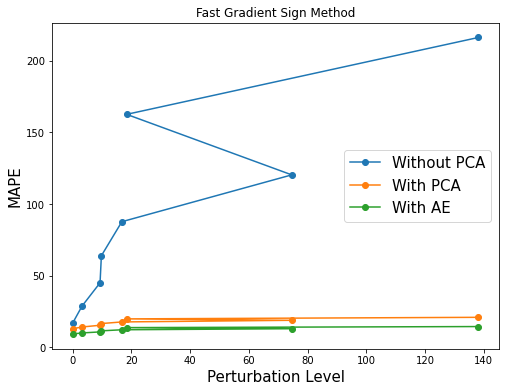

In [25]:
plt.figure(figsize=(8,6))
plt.plot(pert_level, MAPE_BIM, label="Without PCA",marker='o');
plt.plot(pert_level, MAPE_pca_BIM, label="With PCA",marker='o');
plt.plot(pert_level, MAPE_ae_BIM, label="With AE",marker='o');

plt.xlabel("Perturbation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Fast Gradient Sign Method")

#  GAN defense

In [26]:
G = tf.keras.models.load_model('Generator_OPF')
G.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 7)                 577       
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [27]:
####### GAN-based denosing######
MAPE_GAN_BIM = []
r2Score_GAN = []
num_iter = 500
lr_z = 1e-2

dim_noise = 6

for level in levels:
    x_adv = BIM(data_test,level)
    x_adv_re = tf.reshape(x_adv , [x_adv.shape[0]*x_adv.shape[1], x_adv.shape[2]])
    z = tf.random.normal([x_adv.shape[0]*x_adv.shape[1], dim_noise])
    for i in range(num_iter):
        with tf.GradientTape() as g:
            g.watch(z)
            x_gen = G(z)

            x_gen = tf.cast(x_gen,dtype=tf.float64)
            loss = tf.square(x_adv_re - x_gen)
            gradient_adv = g.gradient(loss, z)
            z = z - lr_z*gradient_adv
#             print(gradient_adv.shape)
    x_gen = G(z)
   
    x_gen = tf.reshape(x_gen,[int(x_gen.shape[0]/win_length),win_length,x_gen.shape[1]])
    y_adv = model(x_gen)
    
    y_adv = scaler_output.inverse_transform(y_adv)
    
    epsilon_GAN = mean_absolute_percentage_error(datas_final[['q_inverter']].values,y_adv*(1+level))*100/12
    score_GAN= r2_score(datas_final[['q_inverter']].values,y_adv)
    MAPE_GAN_BIM.append(epsilon_GAN)
    r2Score_GAN.append(score_GAN)
    
    
    

print(MAPE_GAN_BIM)

[6.247370553491884, 6.513827663079582, 6.777098729440328, 6.945215706185272, 7.114158669930737, 7.362028408733632, 7.580248906302045, 7.879228168933864]


Text(0.5, 1.0, 'Basic Iterative Method')

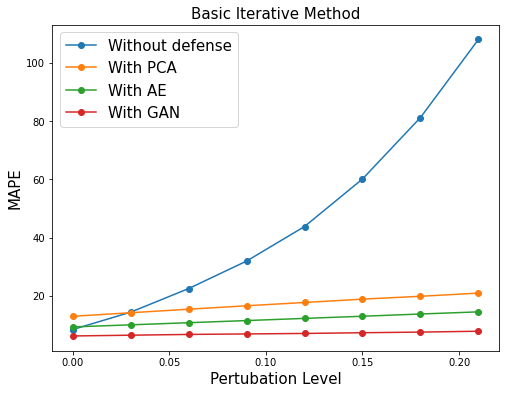

In [35]:
plt.figure(figsize=(8,6))
plt.plot(levels, MAPE_BIM, label="Without defense",marker='o');
plt.plot(levels, MAPE_pca_BIM, label="With PCA",marker='o');
plt.plot(levels, MAPE_ae_BIM, label="With AE",marker='o');
plt.plot(levels, MAPE_GAN_BIM, label="With GAN",marker='o');
plt.xlabel("Pertubation Level",fontsize=15);
plt.ylabel("MAPE",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Basic Iterative Method",fontsize=15)

In [36]:
print('pert_level is',pert_level)
print('MAPE_GAN is',MAPE_GAN_BIM)
print('MAPE_AE is',MAPE_ae_BIM)
print('MAPE_PCA is',MAPE_pca_BIM)
print('MAPE is',MAPE_BIM)

pert_level is [0.0, 3.2182944401177638, 9.343475354237691, 9.79574093344564, 16.774787432975145, 74.62774526296937, 18.39805661910407, 138.20184549637358]
MAPE_GAN is [6.247370553491884, 6.513827663079582, 6.777098729440328, 6.945215706185272, 7.114158669930737, 7.362028408733632, 7.580248906302045, 7.879228168933864]
MAPE_AE is [9.352331625463222, 10.070010021025004, 10.798389747134564, 11.535860465559196, 12.283692153922535, 13.018059205138478, 13.788510817800944, 14.523705177651783]
MAPE_PCA is [12.998578917924638, 14.222074392810788, 15.432835252317725, 16.61468850971567, 17.74684436700414, 18.889749028333807, 19.880415592142516, 20.96235107842375]
MAPE is [8.441776609154324, 14.415251159475467, 22.51134300164299, 31.95574834348605, 43.820654377573035, 60.14334976640079, 81.24424406742904, 108.04898322595375]
